<img src="https://raw.githubusercontent.com/AndresGuarin/Images/main/IA-1/IronProtonXmaxDetectionBanner.png"  width="1040px" height="390px">

[1]

# <center> **Detección del número máximo de partículas de una cascada de astropartículas** </center>

## **Outline**
1. [**Reading data**](#eje1)
2. [**Model Regressor**](#eje2)

## **Descripción**
Durante todo el tiempo la Tierra es bombardeada por diminutas partículas (de tamaño subatómico!) las cuales llamamos astropartículas. Estas nos llegan de grandes eventos del espacio exterior, como explociones de supernova, o eyecciones de materia de agujeros negros del núcleo de una Galaxia. Aún no se sabe con certeza absoluta el origen de estas, por lo que no se descartan otras opciones. Para este trabajo se usarán los datos de las colisiones de hierro y protones con la atmósfera.

<center>
<img src="https://raw.githubusercontent.com/AndresGuarin/Images/main/IA-1/NGC.png" width="350px" height="260px">

<img src="https://raw.githubusercontent.com/AndresGuarin/Images/main/IA-1/supernova.png" width="350px" height="260px">
</center>
[2]

Es inevitable que al caer una partícula sobre la Tierra esta interactúe con la atmósfera. Esto sucede en forma de colisiones. En una colisión la partícula original se deshace y se fragmenta en muchas otras. A este efecto en cadena se le llama cascada! La cascada se compone de un gran número de partículas que se siguen desintegrando y fragmentando antes de llegar al suelo. Cuando están cerca del suelo el número de partículas ya es menor que antes. 

Como cada partícula es diferente, la cascada va a ser distinta dependiendo de la partícula que entró al cielo, por ejemplo el hierro o protón. Entonces el número de partículas máximo de una cascada cambia en función de algunos parámetros como la energía, el ángulo de incidencia o el tipo de partícula.

<center>
<img src="https://raw.githubusercontent.com/AndresGuarin/Images/main/IA-1/astroparticles_shower.jpg" width="300px" height="300px">
</center>
[3]

En este trabajo, nos centramos en hallar el número máximo de partículas de un conjunto de cascadas. El dataset consta de eventos de cascadas debidas al hierro y protones. En total 4400 filas, donde 2300 corresponden al hierro y 2100 al protón. Las features corresponden a 58 caracteristícas de la cascada de astropartículas, como por ejemplo: energía, tamaño angular, posición de la cascada, etc. Se usó un modelo de Regresión para estimar el número máximo de partículas **MC Xmax**.

Los datos fueron obtenidos de simulaciones hechas por investigadores del Observatorio Pierre Auger (Argentina), con datos de entrada basados en detecciones experimentales. Los datos fueron dados por cortesía de Cristian Sarmiento PhD Ciencia y Tecnología, mención Física, quién los usó para su tesis doctoral.

## **Objetivos**

* Aplicar un modelo de regresión para estimar el número máximo de partículas (**MC Xmax**).
* Determinar el mejor modelo que estime el **MC Xmax**.
* Encontrar los parámetros del modelo elegido más apropiados.

## **Estudiantes**

* José Fredy Navarro, 2190044
* Brayan Sneider Daza Suarez, 2190040
* Juan Andrés Guarín Rojas, 2201870

In [ ]:
#@title **MONTAR EL DRIVE** { display-mode: "form" }
import os
from google.colab import drive

path_ai = "/content/drive/My Drive/IA-1/Proyecto" #@param {type:"string"}
path = path_ai
drive.mount('/content/drive')
os.chdir(path)
print(os.getcwd())

Mounted at /content/drive
/content/drive/My Drive/IA-1/Proyecto


In [ ]:
#@title **Load libs** { display-mode: "form" }
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_theme()
pd.__version__
from sklearn.model_selection import KFold, cross_val_score
from sklearn.metrics import *


#1. **Reading data** <a name="eje1"></a>

In [ ]:
# Iron data
iron = pd.read_csv('/data/CutEvents_IronRefDist140.txt',skiprows=2,sep='\t',decimal='.')  #sep='\t' is for tab separator
print(iron.shape)

for col in iron.columns[58:]:  # For cleaning colums of Nans
  del iron[col]
iron.rename(columns = {'M beta syst100000':'M beta syst'}, inplace = True)

# Proton data
proton = pd.read_csv('/data/CutEvents_ProtonRefDist140.txt',sep='\t',decimal='.')
print(proton.shape)

# Concating data
data = pd.concat([iron,proton])
data.index = np.arange(data.shape[0]) 

# Cleaning data
col = data.pop("MC Xmax") # For put the target column 'MC Xmax' at the end of dataframe
data.insert(len(data.columns), col.name, col)

# Delete unnecesary cols
for col in ['runnr', 'rad energy error', '2dLDF sigma error','EE_RdLDF1error','EE_RdLDF3error','EE_RdLDF2error',
            'GeoCe DXmax Error','GeoCe Erad Error', 'N_mu_ref error','M beta error','pvalue GeoCe', 'M beta',
            'Sd rec success']:  # For erasing unrelevant columns
  del data[col]

# Delete rows with meaningless values
drop_rows = []
for i in data.index.values:
  if data.loc[i,'GeoCeXmax'] < 0:
    drop_rows.append(i)
data = data.drop(drop_rows)
data

(2323, 58)
(2142, 58)


,MC energy,MC zenith,MC azimuth,MC core x,MC core y,MC core z,Sd energy,SD zenith,SD azimuth,SD core x,...,GeoCe Erad,GeoCe LDFChi2,GeoCe LDF ndf,Md rec success,N_mu_ref,MLDF Chi2,MLDF NDF,MLDF Likelihood,M beta syst,MC Xmax
0,1.549610e+18,41.0088,303.544,449498,6113960.0,1468.23,1.158430e+18,40.7990,303.8270,449483,...,17483200.0,1.187590,2,1,2.375530,42.65270,42,26.63010,0,641.545
1,2.535990e+17,34.4273,204.927,450569,6114990.0,1468.11,2.077700e+17,33.5715,204.8110,450442,...,381955.0,0.298539,1,1,0.603343,11.23330,12,7.14209,0,586.647
2,2.557910e+17,41.8761,291.040,449957,6114220.0,1468.64,1.495360e+17,41.4153,289.9990,449994,...,577101.0,0.141620,2,1,0.460631,9.15930,12,5.93662,0,556.775
3,1.478830e+18,48.8578,163.620,450725,6114750.0,1466.90,1.204640e+18,48.5606,163.8390,450769,...,16757200.0,80.785400,18,1,2.482500,60.65770,49,38.28580,0,651.333
4,7.992670e+17,47.9999,20.302,448781,6114250.0,1478.29,6.018360e+17,48.3129,20.4129,448726,...,3505110.0,2.242340,3,1,1.531090,21.60800,24,13.32660,0,660.695
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4460,2.830380e+17,42.1923,299.907,450837,6114940.0,1464.25,2.847940e+17,41.5514,297.6510,450778,...,654295.0,84.270400,9,1,0.673622,16.09300,13,10.76710,0,716.003
4461,7.031340e+16,31.5730,313.950,451208,6114290.0,1459.11,7.495520e+16,33.6773,313.9710,451062,...,60215.1,11.750800,5,1,0.197141,4.87348,6,4.92578,0,621.258
4462,2.081160e+18,31.6012,100.132,450405,6114330.0,1466.43,1.727270e+18,32.1312,99.8235,450409,...,10723500.0,5.103520,1,1,2.475100,63.56010,45,36.74840,0,741.709
4463,3.655930e+17,54.1971,240.092,450736,6114530.0,1463.18,2.899870e+17,53.4601,240.9910,450679,...,1122320.0,59.044000,18,1,0.375106,10.20190,9,8.00254,0,690.726


#2. **Model Regressor** <a name="eje2"></a>

In [ ]:
#@ title **code** Train model
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import mean_squared_error

print(data.shape)

# Get data
X = data.values[:,:-1]
y = data.values[:,-1]

# Make Partition
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=True)

# Call and train model
est = DecisionTreeRegressor()
est.fit(X_train,y_train)

s = np.sqrt(mean_squared_error(y_test, est.predict(X_test)))
print('RMSE: ',s)
features = est.feature_importances_ 
print('\nFeautres importances: \n',features)

#Choose best features
n=4
bestfeat = np.argsort(features)[-n:]
X_train_best = X_train[:,bestfeat]
X_test_best = X_test[:,bestfeat] 
         
# Variar n para observar mejores caracteristicas             
print('\nBest features: \n',data.columns[bestfeat],'\n')
print(X_train_best.shape)

(4459, 45)
RMSE:  57.08747138618015

Feautres importances: 
 [0.04201841 0.01078847 0.01098217 0.00905803 0.01059274 0.02108036
 0.01295412 0.04049385 0.00591353 0.01050993 0.0044891  0.0030447
 0.         0.00402749 0.02288882 0.00721647 0.01308626 0.01337691
 0.00843705 0.01561375 0.01227632 0.12339166 0.01430669 0.00221928
 0.01516432 0.02276659 0.01917998 0.00931034 0.00710826 0.02865645
 0.02582071 0.00182094 0.00620501 0.01795664 0.26539609 0.02225388
 0.04116031 0.0021815  0.         0.05344653 0.02062123 0.00941551
 0.01276958 0.        ]

Best features: 
 Index(['MC energy', 'N_mu_ref', '2dLDF sigma', 'GeoCeXmax'], dtype='object') 

(3567, 4)


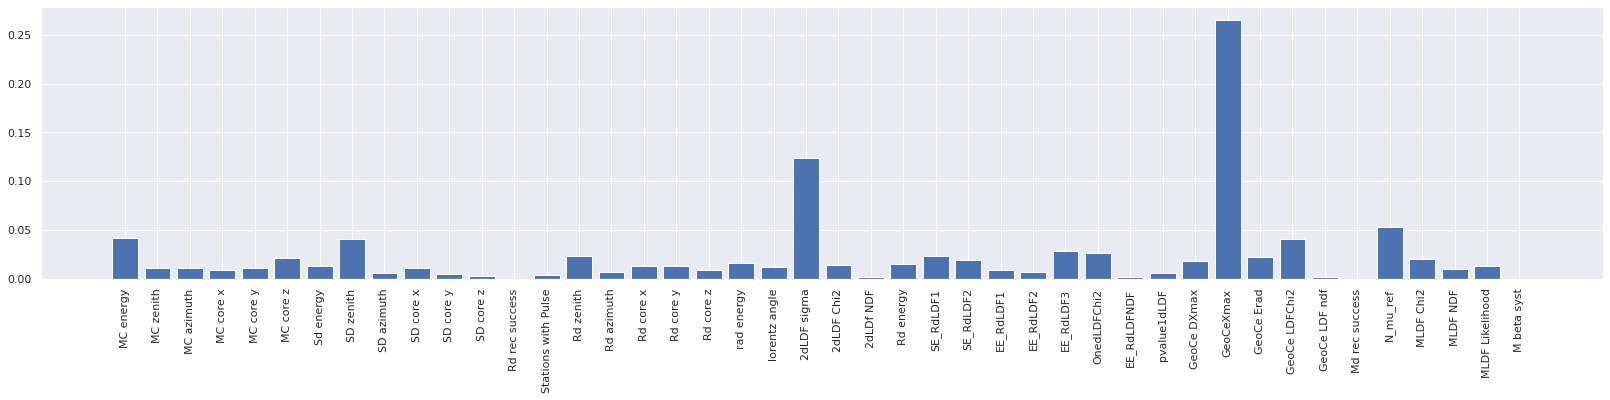

In [ ]:
#@ title **code** Visualize best features
f = plt.figure(figsize=(28,5))
f.subplots_adjust(wspace=0.5)
ax = f.add_subplot(111)
plt.bar(range(len(features)),features)
plt.xticks(range(len(features)),data.columns[:-1],rotation='vertical')
plt.show()

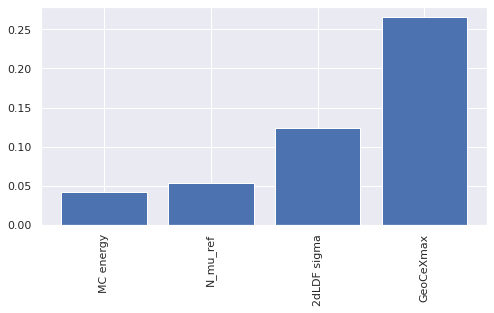

In [ ]:
#@ title **code** Visualize best features choosen
f = plt.figure(figsize=(8,4))
f.subplots_adjust(wspace=0.5)
ax = f.add_subplot(111)
plt.bar(range(len(features[bestfeat])),features[bestfeat])
plt.xticks(range(len(bestfeat)),data.columns[bestfeat],rotation='vertical')
plt.show()

## **Variables Físicas**
* **MC_energy:** Energía partícula entrante.
* **N_mu_ref:** Número de muónes que genera la lluvía al caer al suelo.
* **2dLDF_sigma:** Radio del área de esparcimiento de la lluvía (donde la lluvia tiene forma de cono con la punta apuntando hacía el punto donde entró la partícula).
* **GeoCeXmax:** Es el **Xmax** medido por los detectores de radio (RD, por sus siglas en inglés).


In [ ]:
#@ title **code** Random Forest Regressor
from sklearn.metrics import mean_squared_error
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.svm import SVR
from sklearn.model_selection import LeaveOneOut

# Call and train model
est = RandomForestRegressor(n_estimators=20, max_depth=4)
est.fit(X_train_best,y_train)

pred = est.predict(X_test_best)
s1 = np.sqrt(mean_squared_error(pred,y_test))
print('RMSE: ',s1)

s2 = mean_absolute_percentage_error(pred,y_test)
print('MAPE: ',s2)

RMSE:  44.620772948854416
MAPE:  0.053458864750662013


## **Choose best parameters**

In [ ]:
#@ title **code** Running models

# Parameters for choose
estimators = [5, 10, 15, 30, 40]
depths = [3, 5, 7, 15, 30]

M1 = np.zeros((len(estimators),len(depths)))
M2 = M1.copy()

# Run Random Forest Regressor for any estimator and depth choosen
for i, n_estimators in enumerate(estimators):
  for j, max_depth in enumerate(depths):

    # Call and train model
    est = RandomForestRegressor(n_estimators=n_estimators, random_state=21, max_depth=max_depth)
    est.fit(X_train_best,y_train)
    
    # Predict model
    pred = est.predict(X_test_best)
    s1 = np.sqrt(mean_squared_error(pred,y_test))    # Mean Squared Error
    s2 = mean_absolute_percentage_error(pred,y_test) # Mean Absolute Percentage Error
    M1[i,j] = s1
    M2[i,j] = s2

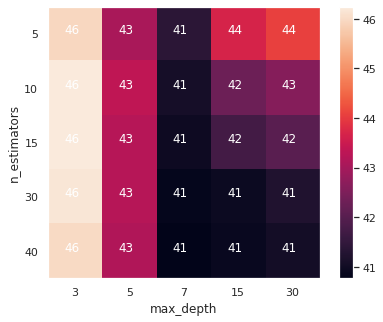

In [ ]:
#@ title **code** Plotting results
def plot_text(M):
  for i,row in enumerate(M):
    for j, col in enumerate(row):
      if M[i,j] > 47.5:
        color='black'
      else:
        color='white'
      plt.text(j-0.2,i,'%1.f'%(M[i,j]), color=color)

plt.figure(figsize=(7,5))
plt.imshow(M1)
plt.colorbar()
plot_text(M1)
plt.xlabel('max_depth')
plt.ylabel('n_estimators')
plt.yticks(range(len(estimators)),estimators)
plt.xticks(range(len(depths)),depths)
plt.grid(False)
plt.show()

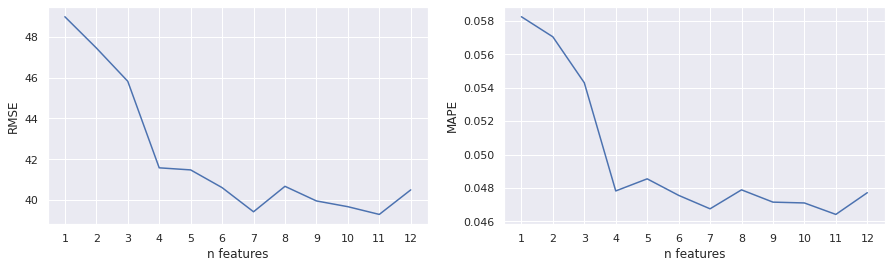

In [ ]:
#@ title **code** Learning Curves
N=12
estimators = 10
max_depth = 7
s1=[]
s2=[]

for n in range(1,N+1):
    # Get data
    bestfeat = np.argsort(features)[-n:]
    X_train_best = X_train[:,bestfeat]
    X_test_best = X_test[:,bestfeat] 
  
   # Call and train model
    est = RandomForestRegressor(n_estimators=estimators, max_depth=max_depth)
    est.fit(X_train_best,y_train)

    # Predict
    pred = est.predict(X_test_best)
    s1.append(np.sqrt(mean_squared_error(pred,y_test)))     # Mean Squared Error
    s2.append(mean_absolute_percentage_error(pred,y_test))  # Mean Absolute Percentage Error

#Plot results
plt.figure(figsize=(15,4))
plt.subplot(121)
plt.plot(np.arange(N),s1)
plt.ylabel('RMSE')
plt.xlabel('n features')
plt.xticks(range(N), np.arange(N)+1)

plt.subplot(122)
plt.plot(np.arange(N),s2)
plt.ylabel('MAPE')
plt.xlabel('n features')
plt.xticks(range(N), np.arange(N)+1)
plt.show()

In [ ]:
#@ title **code** Random Forest Regressor
from sklearn.metrics import mean_squared_error
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.svm import SVR

estimators = 10
max_depth = 7
n=7

# Get data
bestfeat = np.argsort(features)[-n:]
X_train_best = X_train[:,bestfeat]
X_test_best = X_test[:,bestfeat] 
  
# Call and train model
est = RandomForestRegressor(n_estimators=estimators, random_state=21, max_depth=max_depth)
est.fit(X_train_best,y_train)

pred = est.predict(X_test_best)
s1 = np.sqrt(mean_squared_error(pred,y_test))
print('RMSE: ',s1)

s2 = mean_absolute_percentage_error(pred,y_test)
print('MAPE: ',s2)

RMSE:  39.779959821452564
MAPE:  0.046784140150593255


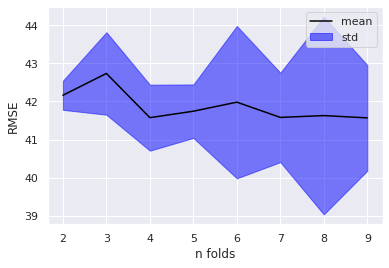

In [ ]:
#@ title **code** Cross-validation score
#@ markdown **Note:** It's recomended to run the previous cell before runnig this.

s_mean, s_std = [], []
nfolds_range = range(2,10)

# Create cycle for running the estimator for any nfold in nfolds_range
for nfolds in nfolds_range:  
  s = cross_val_score(est, X, y, cv=KFold(nfolds, shuffle=True), scoring=make_scorer(mean_squared_error))
  s_mean.append(np.mean(np.sqrt(s)))
  s_std.append(np.std(np.sqrt(s)))

s_mean = np.r_[s_mean]
s_std = np.r_[s_std]

# Plot results
plt.plot(nfolds_range, s_mean, label="mean", color="black")
plt.fill_between(nfolds_range, s_mean-s_std, s_mean+s_std, color="blue", alpha=.5, label="std")
plt.xlabel("n folds")
plt.ylabel("RMSE")
plt.legend()
plt.show()

# **Conclusiones**

* Usando las best_features del Decision Tree, se redujo la cantidad de caracteristícas para estimar el **Xmax** (número máximo de partículas) de la cascada de una colisión de un hierro o un protón con la Tierra.

* Al identificar los mejores parámetros del Random Forest Regressor y de la cantidad de best_features de entrenamiento, se logró construir un regresor óptimo para obtener los valores de **Xmax** con unos de los menores errores posibles.

* El modelo obtuvo un error MAPE (Mean Absolute Percentage error) del 4.7% respecto a la media de los datos de **MC Xmax**.

# **Referencias Imágenes**

[1] The University of Adelaide (2019). Studying the Highest Energy Particles in Nature with the Pierre Auger Observatory. *News*. URL: https://set.adelaide.edu.au/news/list/2019/01/01/studying-the-highest-energy-particles-in-nature-with-the-pierre-auger

[2] Observatorio Pierre Auger [página oficial] (s.f.). ¿Qué son los rayos cósmicos?. URL: https://visitantes.auger.org.ar/index.php/ique-son-los-rayos-cosmicos-2/

[3] augervalveimage.blogspot.com (2010). Pierre Auger Observatory [Blog]. URL: http://augervalveimage.blogspot.com/2013/09/pierre-auger-observatory.html

## **Anexos**

### **Exploración de los datos de protón y hierro**

In [ ]:
#@ title **code** MC Xmax of iron and proton
#display(particles['MC Xmax'])
#particles['GeoCeXmax']
print('MC Xmax Iron:    %.4f +/- %.4f'%(np.mean(iron['MC Xmax'].values), np.std(iron['MC Xmax'].values)))
print('GeoCeXmax Iron:  %.4f +/- %.4f'%(np.mean(iron['GeoCeXmax'].values), np.std(iron['GeoCeXmax'].values)))
print()
print('MC Xmax Proton:    %.4f +/- %.4f'%(np.mean(proton['MC Xmax'].values), np.std(proton['MC Xmax'].values)))
print('GeoCeXmax Proton:  %.4f +/- %.4f'%(np.mean(proton['GeoCeXmax'].values), np.std(proton['GeoCeXmax'].values)))

MC Xmax Iron:    622.7639 +/- 30.5248
GeoCeXmax Iron:  638.0860 +/- 94.3897

MC Xmax Proton:    706.0959 +/- 47.8885
GeoCeXmax Proton:  683.4042 +/- 87.8247


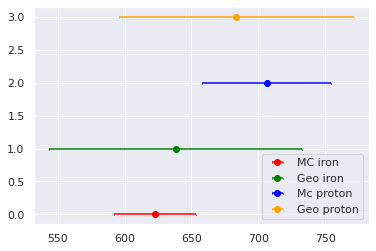

In [ ]:
#@ title **code** Visualize MC Xmax of iron and proton
x = [np.mean(iron['MC Xmax'].values), np.mean(iron['GeoCeXmax'].values), np.mean(proton['MC Xmax'].values),np.mean(proton['GeoCeXmax'].values)]
y = range(4)
dx = [np.std(iron['MC Xmax'].values), np.std(iron['GeoCeXmax'].values), np.std(proton['MC Xmax'].values),np.std(proton['GeoCeXmax'].values)]
color = ['red','green','blue','orange']
label = ['MC iron','Geo iron','Mc proton','Geo proton']
for i in range(4):
  plt.errorbar(x[i],y[i],fmt='o',xerr=dx[i],color=color[i], label=label[i],capsize=0.5)
plt.legend()
plt.show()

### **Variación de Parámetros**

In [ ]:
#@ title **code** Running models

# Parameters for choose
estimators = [5, 10, 15, 30, 40]
depths = [3, 5, 7, 15, 30]
N = [4, 5, 6]

M1 = []
M2 = []
for i, n in enumerate(N):
  # Get data
  bestfeat = np.argsort(features)[-n:]
  X_train_best = X_train[:,bestfeat]
  X_test_best = X_test[:,bestfeat] 

  M1_ = np.zeros((len(estimators),len(depths)))
  M2_ = M1_.copy()

  # Run Random Forest Regressor for any estimator and depth choosen
  for i, n_estimators in enumerate(estimators):
    for j, max_depth in enumerate(depths):

      # Call and train model
      est = RandomForestRegressor(n_estimators=n_estimators, max_depth=max_depth, random_state=21)
      est.fit(X_train_best,y_train)
      
      # Predict model
      pred = est.predict(X_test_best)
      s1 = np.sqrt(mean_squared_error(pred,y_test))    # Mean Squared Error
      s2 = mean_absolute_percentage_error(pred,y_test) # Mean Absolute Percentage Error
      M1_[i,j] = s1
      M2_[i,j] = s2
  
  # Save matrices of errors
  M1.append(M1_)
  M2.append(M2_)

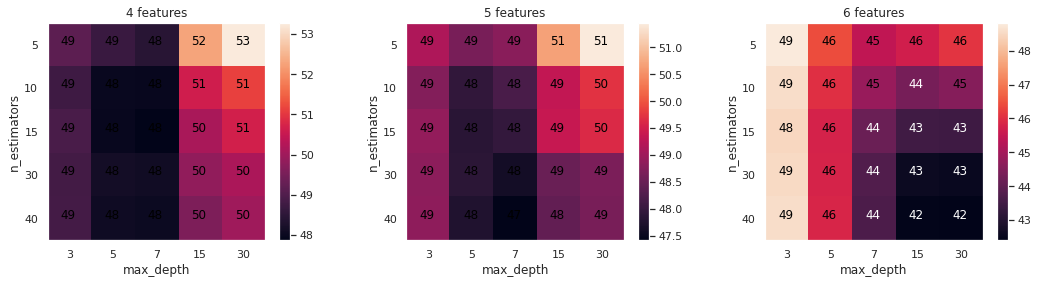

In [ ]:
#@ title **code** Plotting results
def plot_text(M):
  for i,row in enumerate(M):
    for j, col in enumerate(row):
      if M[i,j] > 44.5:
        color='black'
      else:
        color='white'
      plt.text(j-0.2,i,'%1.f'%(M[i,j]), color=color)

f = plt.figure(figsize=(18,4))
f.subplots_adjust(wspace=0.25)
for i in range(3):
  plt.subplot(1,3,i+1)
  plt.imshow(M1[i])
  plt.colorbar()
  plot_text(M1[i])
  plt.title(str(N[i])+' features')
  plt.xlabel('max_depth')
  plt.ylabel('n_estimators')
  plt.yticks(range(len(estimators)),estimators)
  plt.xticks(range(len(depths)),depths)
  plt.grid(False)
plt.show()